In [1]:
# https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/

import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical CPU, 1 Logical CPU


In [2]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception # TensorFlow ONLY
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import argparse
import cv2

In [3]:
# define a dictionary that maps model names to their classes
# inside Keras
MODELS = {
	"vgg16": VGG16,
	"vgg19": VGG19,
	"inception": InceptionV3,
	"xception": Xception, # TensorFlow ONLY
	"resnet": ResNet50
}
SHAPES = {
	"vgg16": (224, 224),
	"vgg19": (224, 224),
	"inception": (299, 299),
	"xception": (299, 299), # TensorFlow ONLY
	"resnet": (224, 224)
}

In [4]:
# initialize the input image shape (224x224 pixels) along with
# the pre-processing function (this might need to be changed
# based on which model we use to classify our image)
inputShape = (224, 224)
preprocess = imagenet_utils.preprocess_input
inputShape2 = (299, 299)
# if we are using the InceptionV3 or Xception networks, then we
# need to set the input shape to (299x299) [rather than (224x224)]
# and use a different image pre-processing function
#if args["model"] in ("inception", "xception"):
#	inputShape = (299, 299)
#	preprocess = preprocess_input

In [5]:
# load our the network weights from disk (NOTE: if this is the
# first time you are running this script for a given network, the
# weights will need to be downloaded first -- depending on which
# network you are using, the weights can be 90-575MB, so be
# patient; the weights will be cached and subsequent runs of this
# script will be *much* faster)

NETWORKS = {
	"vgg16": VGG16,
	"vgg19": VGG19,
	"inception": InceptionV3,
	"xception": Xception, # TensorFlow ONLY
	"resnet": ResNet50
}
for MyMODEL in MODELS:
    print("[INFO] loading {}...".format(MyMODEL))
    MyNETWORK = MODELS[MyMODEL]
    NETWORKS[MyMODEL] = MyNETWORK(weights="imagenet")

[INFO] loading vgg16...
553467904/553467096 [==============================] - 8s 0us/step
[INFO] loading vgg19...
574717952/574710816 [==============================] - 8s 0us/step
[INFO] loading inception...
96116736/96112376 [==============================] - 2s 0us/step
[INFO] loading xception...
91889664/91884032 [==============================] - 2s 0us/step
[INFO] loading resnet...
102973440/102967424 [==============================] - 2s 0us/step


In [6]:
!wget -c https://ichef.bbci.co.uk/news/976/cpsprodpb/41CF/production/_109474861_angrycat-index-getty3-3.jpg

"""
inputdir = '/kaggle/working'
"""

inputdir = '/content'

--2020-12-13 00:08:05--  https://ichef.bbci.co.uk/news/976/cpsprodpb/41CF/production/_109474861_angrycat-index-getty3-3.jpg
Resolving ichef.bbci.co.uk (ichef.bbci.co.uk)... 95.101.59.186, 2a02:26f0:b200:395::f33, 2a02:26f0:b200:3a3::f33, ...
Connecting to ichef.bbci.co.uk (ichef.bbci.co.uk)|95.101.59.186|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61060 (60K) [image/jpeg]
Saving to: ‘_109474861_angrycat-index-getty3-3.jpg’

_109474861_angrycat 100%[===================>]  59.63K  --.-KB/s    in 0.006s  

2020-12-13 00:08:05 (9.03 MB/s) - ‘_109474861_angrycat-index-getty3-3.jpg’ saved [61060/61060]



In [7]:
# load the input image using the Keras helper utility while ensuring
# the image is resized to `inputShape`, the required input dimensions
# for the ImageNet pre-trained network
print("[INFO] loading and pre-processing image...")
filename = os.path.join(inputdir, '_109474861_angrycat-index-getty3-3.jpg')
image1 = load_img(filename, target_size=(224, 224))
image1 = img_to_array(image1)
image2 = load_img(filename, target_size=(224, 224))
image2 = img_to_array(image2)

# our input image is now represented as a NumPy array of shape
# (inputShape[0], inputShape[1], 3) however we need to expand the
# dimension by making the shape (1, inputShape[0], inputShape[1], 3)
# so we can pass it through the network
image1 = np.expand_dims(image1, axis=0)
image2 = np.expand_dims(image2, axis=0)
# pre-process the image using the appropriate function based on the
# model that has been loaded (i.e., mean subtraction, scaling, etc.)
image1 = preprocess(image1)
image2 = preprocess(image2)

[INFO] loading and pre-processing image...


In [8]:
# classify the image
PREDS = {}
for MyNETWORK in NETWORKS:
    print("[INFO] classifying image with '{}'...".format(MyNETWORK))
    if SHAPES[MyNETWORK] == (224, 224):
        PREDS[MyNETWORK] = imagenet_utils.decode_predictions(NETWORKS[MyNETWORK].predict(image1))
    if SHAPES[MyNETWORK] == (299, 299):
        PREDS[MyNETWORK] = imagenet_utils.decode_predictions(NETWORKS[MyNETWORK].predict(image2))

#print("[INFO] classifying image with '{}'...".format(args["model"]))
#preds = model.predict(image)
#P = imagenet_utils.decode_predictions(preds)
# loop over the predictions and display the rank-5 predictions +
# probabilities to our terminal
for N1, P in PREDS.items():
    for (i, (imagenetID, label, prob)) in enumerate(P[0]):
        print("MODEL: {} / {}. {}: {:.2f}%".format(N1, i + 1, label, prob * 100))

[INFO] classifying image with 'vgg16'...
40960/35363 [==================================] - 0s 0us/step
[INFO] classifying image with 'vgg19'...
[INFO] classifying image with 'inception'...
[INFO] classifying image with 'xception'...
[INFO] classifying image with 'resnet'...
MODEL: vgg16 / 1. tabby: 56.18%
MODEL: vgg16 / 2. tiger_cat: 17.59%
MODEL: vgg16 / 3. Egyptian_cat: 15.43%
MODEL: vgg16 / 4. bow_tie: 2.36%
MODEL: vgg16 / 5. hamster: 1.21%
MODEL: vgg19 / 1. tiger_cat: 44.09%
MODEL: vgg19 / 2. tabby: 39.57%
MODEL: vgg19 / 3. Egyptian_cat: 5.28%
MODEL: vgg19 / 4. lynx: 3.06%
MODEL: vgg19 / 5. Persian_cat: 1.33%
MODEL: inception / 1. stole: 79.69%
MODEL: inception / 2. chainlink_fence: 20.23%
MODEL: inception / 3. vase: 0.05%
MODEL: inception / 4. ashcan: 0.01%
MODEL: inception / 5. hammer: 0.00%
MODEL: xception / 1. ping-pong_ball: 99.85%
MODEL: xception / 2. military_uniform: 0.07%
MODEL: xception / 3. keeshond: 0.04%
MODEL: xception / 4. backpack: 0.01%
MODEL: xception / 5. web_si

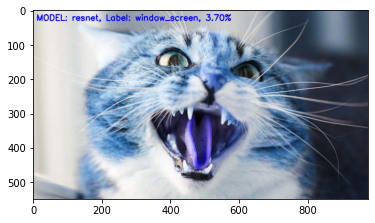

In [9]:
# load the image via OpenCV, draw the top prediction on the image,
# and display the image to our screen

from matplotlib import pyplot as plt
%matplotlib inline

for N1, P in PREDS.items():
    for (i, (imagenetID, label, prob)) in enumerate(P[0]):
        orig = cv2.imread(filename)
        cv2.putText(orig, "MODEL: {}, Label: {}, {:.2f}%".format(N1, label, prob * 100), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        plt.imshow(orig)
        #cv2.imshow("Classification", orig)
        #cv2.waitKey(0)